In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-mnist-ham10000:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F54339%2F104884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T134453Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbc743a3a4b603e1d75f978592dd7a89f1ef597b5c21124fca689b08ed09d3ae26e4c75cee941ae99109f214fff7597611b69df95f4eb79afb662a3d7cc131bf271562638a5658dfb4ec284e32c404e5a6b37e9bc168c5f795390186399f0ddebb9ee7f6ee9c7020c2d82c05f5f9d7e08ff750d1f91c20e7c37bb2c0be177cd7819cb49ed743ec1f4f77bf121cd1e002bfb8eef2ef7d6f111d9a0432e84a2978e53b4bd649d2f286aa84bbc3a122453b4280b1b7b7453df533adcf389086ff056bf39f36059f66d525e589b97b34700edda913a9a360283e74416e3ca411bbe7c06542c7e89b11d55059e4661e038877238484fc4b2b08877456b5dcda4a381bc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5582914511 bytes downloaded
Downloaded and uncompressed: skin-cancer-mnist-ham10000
Data source import complete.


# Importing Libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Import Data

In [ ]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [ ]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

# Frequency Distribution of Classes

Text(0.5, 1.0, 'Frequency Distribution of Classes')

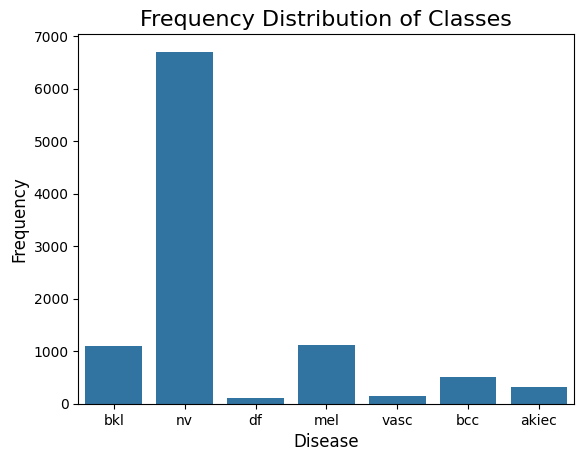

In [ ]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

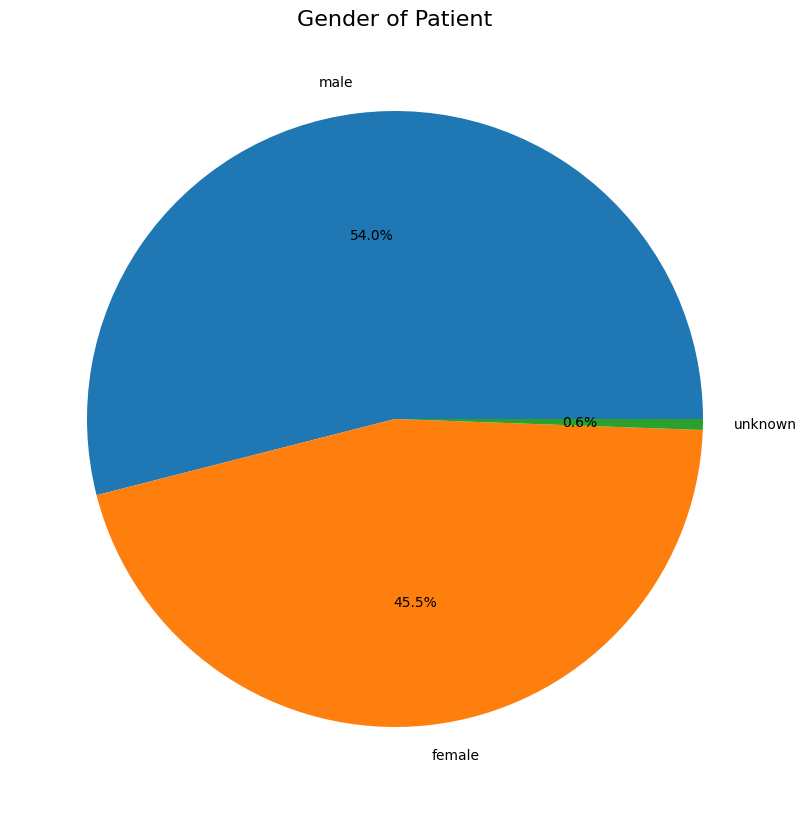

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

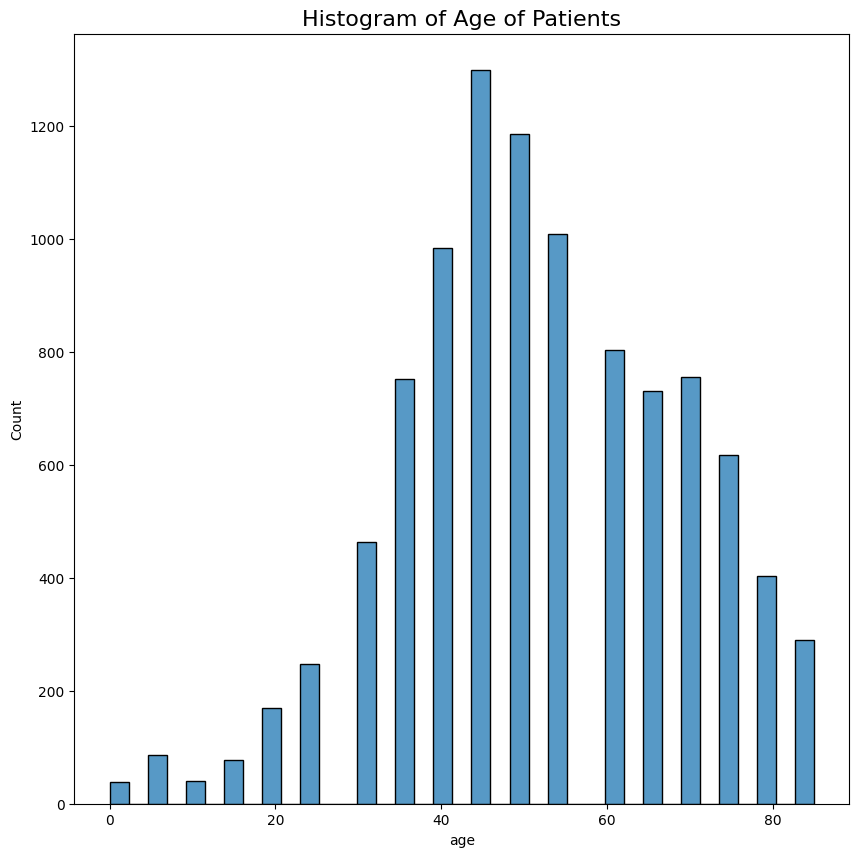

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

# Location of disease over Gender

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

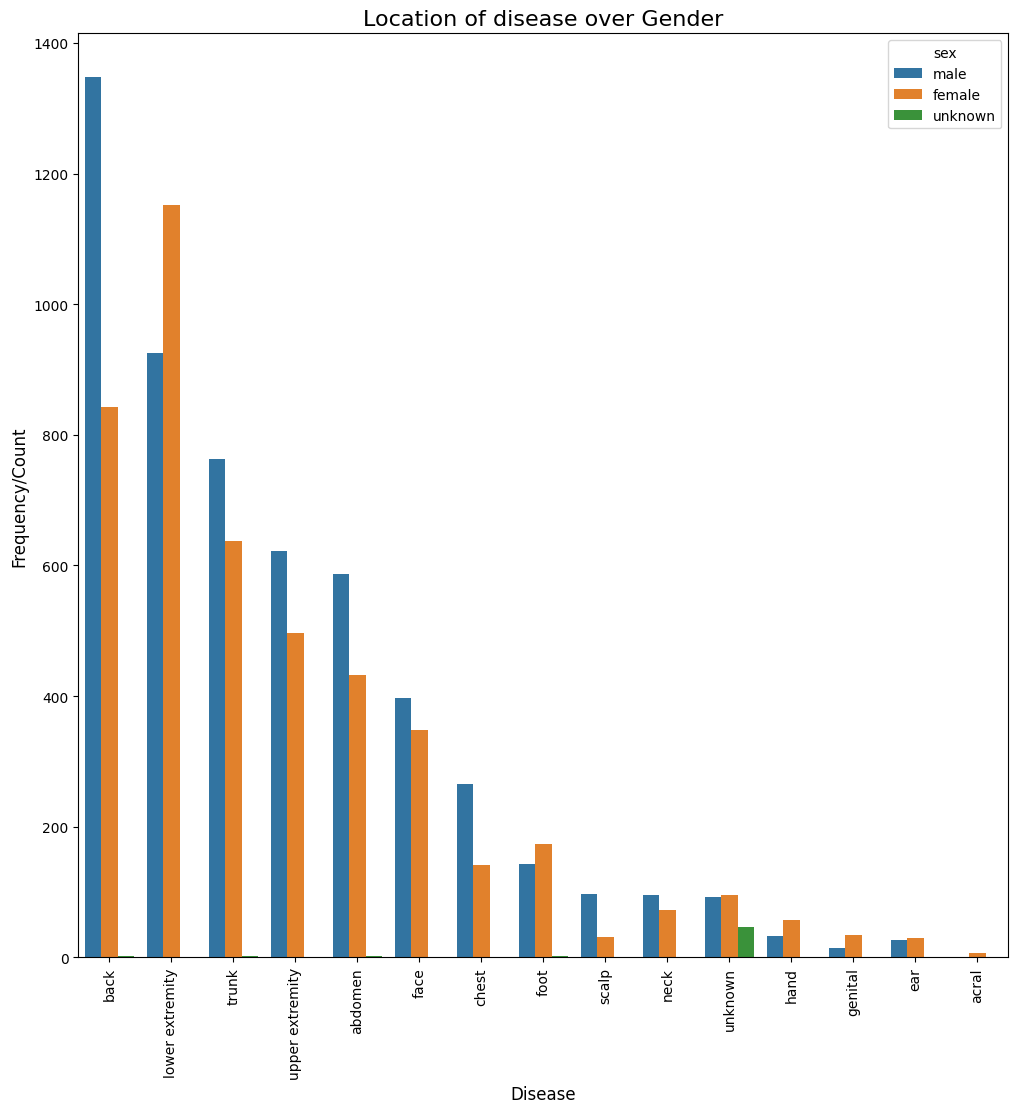

In [ ]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Oversampling
**To overcome class imbalace**

In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


# Standardization and Splitting Data

In [ ]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# Model Training

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                   

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9837
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 62s 255ms/step - loss: 0.0458 - accuracy: 0.9837 - val_loss: 0.1827 - val_accuracy: 0.9510
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9875
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 56s 239ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.2112 - val_accuracy: 0.9501
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9820
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 56s 240ms/step - loss: 0.0543 - accuracy: 0.9820 - val_loss: 0.2328 - val_accuracy: 0.9474
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9891
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 56s 238ms/step 

# Plot Accuracy and Loss

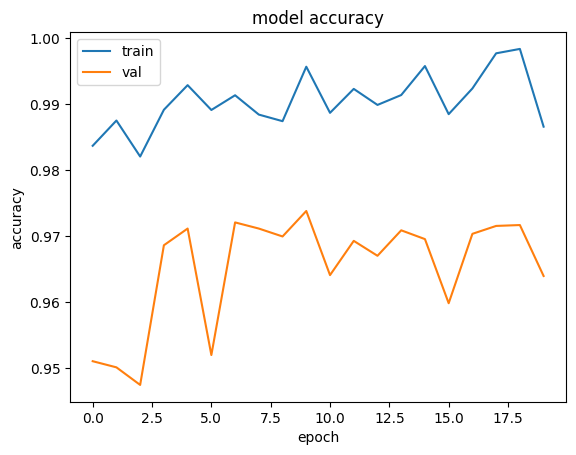

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

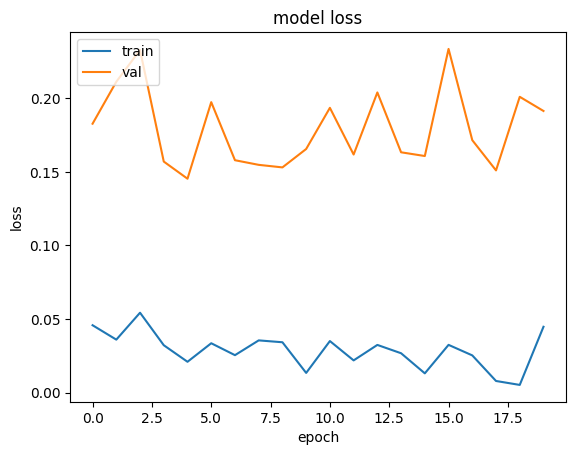

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.h5')


# Model Testing

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 5s - loss: 0.1799 - accuracy: 0.9661 - 5s/epoch - 16ms/step


# Model Inference

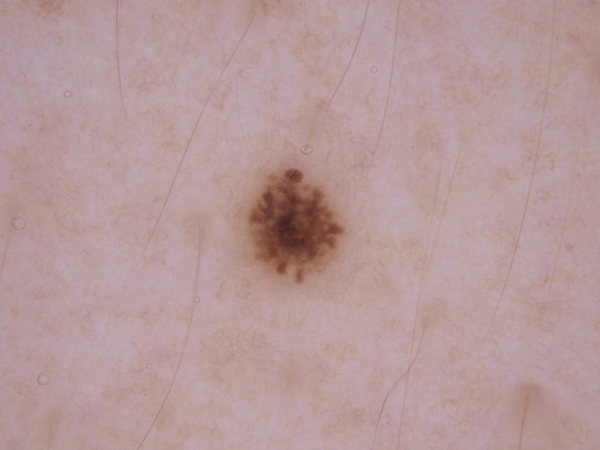

1/1 [==============================] - 0s 174ms/step
('nv', ' melanocytic nevi')


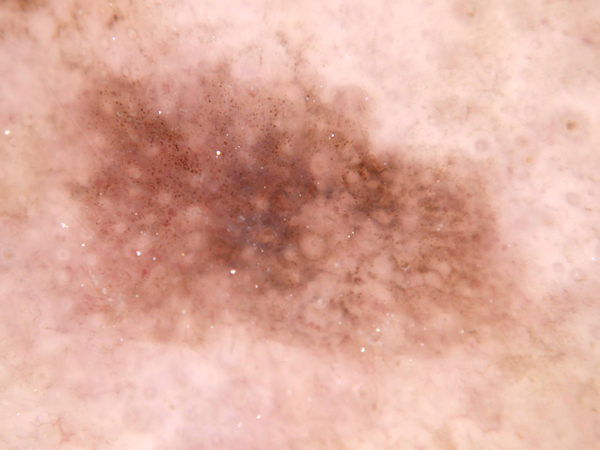

1/1 [==============================] - 0s 34ms/step
('bcc', ' basal cell carcinoma')


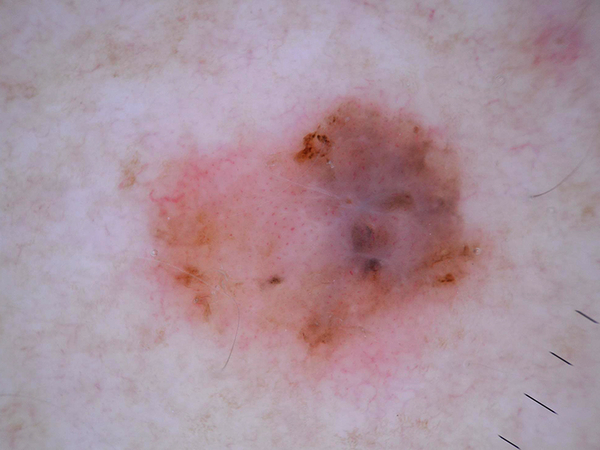

1/1 [==============================] - 0s 31ms/step
('bcc', ' basal cell carcinoma')


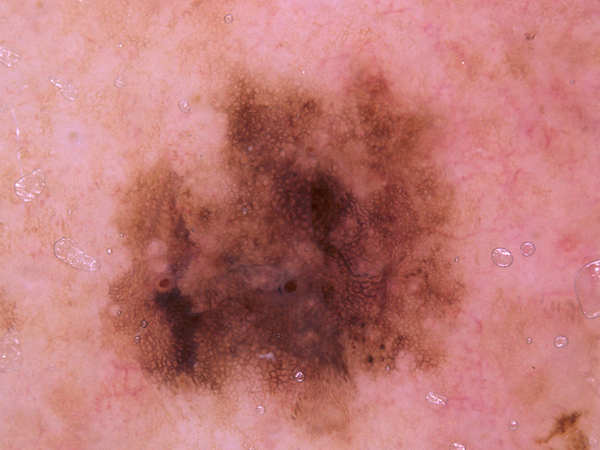

1/1 [==============================] - 0s 33ms/step
('nv', ' melanocytic nevi')


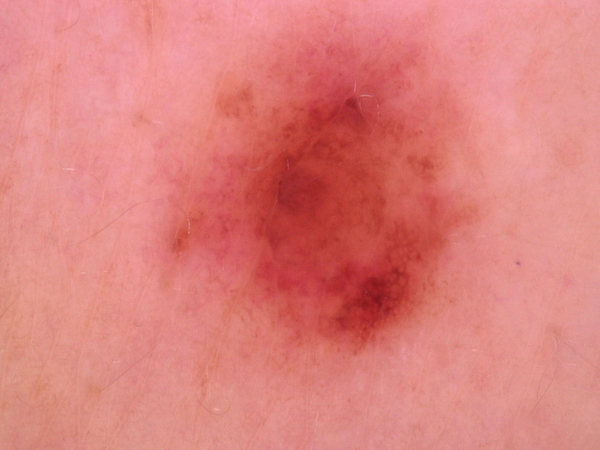

1/1 [==============================] - 0s 39ms/step
('bcc', ' basal cell carcinoma')


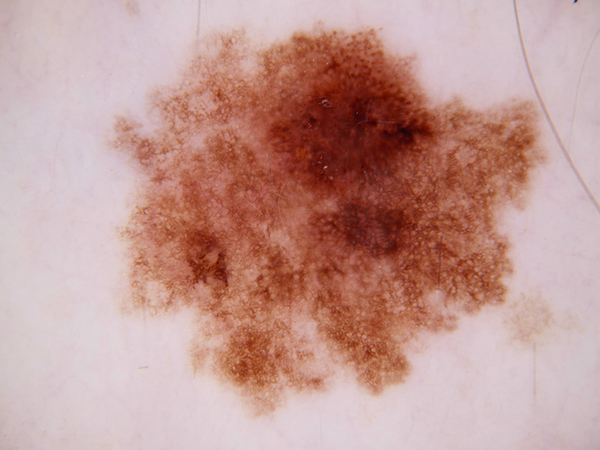

1/1 [==============================] - 0s 32ms/step
('bcc', ' basal cell carcinoma')


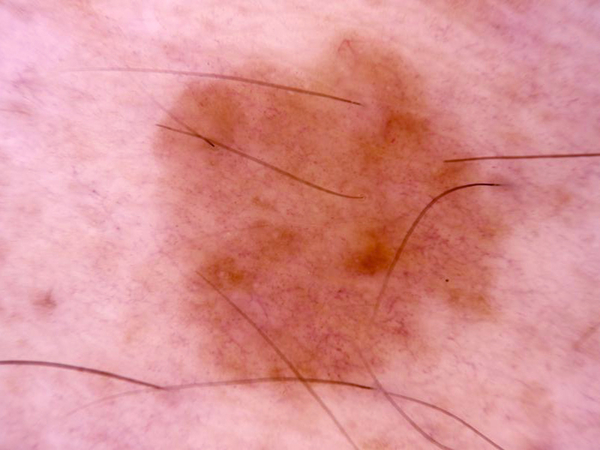

1/1 [==============================] - 0s 35ms/step
('bcc', ' basal cell carcinoma')


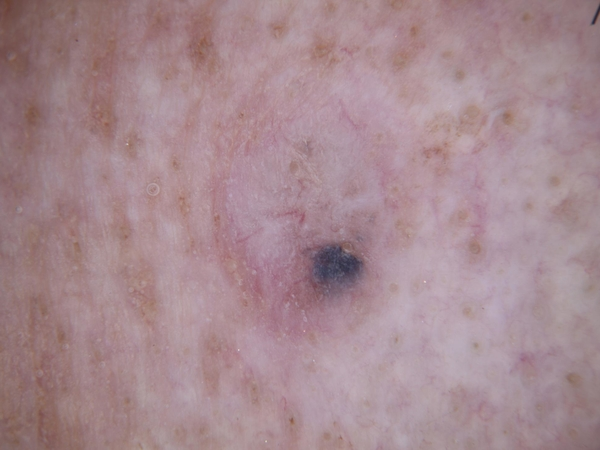

1/1 [==============================] - 0s 52ms/step
('bcc', ' basal cell carcinoma')


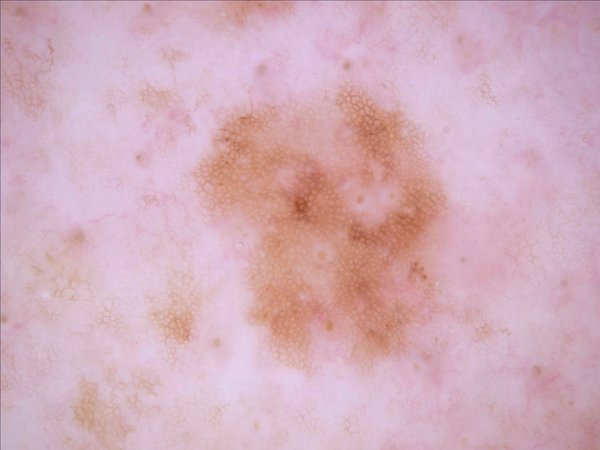

1/1 [==============================] - 0s 33ms/step
('bcc', ' basal cell carcinoma')


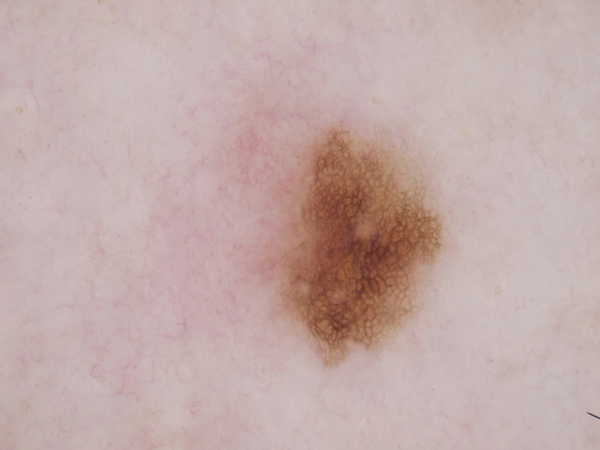

1/1 [==============================] - 0s 31ms/step
('nv', ' melanocytic nevi')


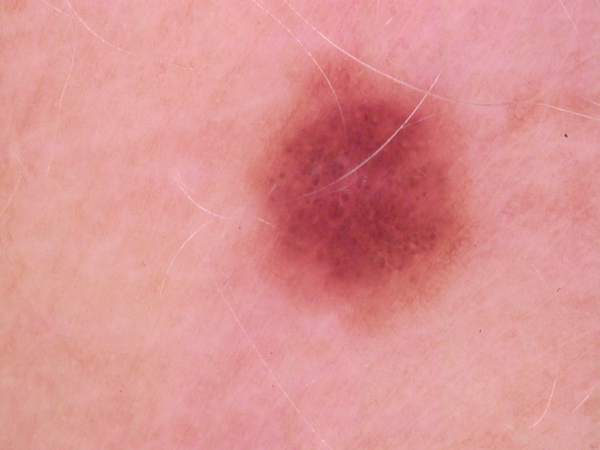

1/1 [==============================] - 0s 36ms/step
('nv', ' melanocytic nevi')


In [ ]:
!pip install google.colab
from google.colab.patches import cv2_imshow
srcdir = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
count=0
for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2_imshow(img)
    img = cv2.resize(img, (28, 28))
    result = model.predict(img.reshape(1, 28, 28, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>10:
        break